# Single Variable RNN Model for Hurricane Path Forestcasting

In [57]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.decomposition import PCA

In [8]:
from tensorflow.keras.optimizers import Adam

In [238]:
tf.debugging.set_log_device_placement(False)
print(tf.config.get_visible_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preproccessing Hurricane Data

The aim here is to build and evaulate a range of, baseline, single variable RNNs for hurricane forecasting. Hence, the only data we require is location (in the form of Longitude and Latitude) and time, the rest may be omitted as follows.

In [263]:
# Obtain Cyclone Data
df = pd.read_csv("../raw-data/hurricaneData.csv")

In [264]:
df.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG
0,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 16:00:00,NR,16.5,124.0,,,,main,165,145,___________O___
1,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 18:00:00,NR,16.5,123.8,,,,main,145,111,___________P___
2,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 21:00:00,NR,16.6,123.5,,,,main,111,77,___________P___
3,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-25 00:00:00,NR,16.7,123.2,,,,main,77,44,___________P___
4,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-25 03:00:00,NR,16.8,122.9,,,,main,44,33,___________P___


In [265]:
# Drop all attributes, expect Longitude, Latitude, Time and SID
simple_df = df.drop(['SEASON','NUMBER','BASIN','SUBBASIN','NAME','NATURE','WMO_WIND','WMO_PRES','WMO_AGENCY','TRACK_TYPE','DIST2LAND','LANDFALL','IFLAG'],axis=1)

In [266]:
# Simplified dataframe
simple_df.head()

,SID,ISO_TIME,LAT,LON
0,1884177N17124,1884-06-24 16:00:00,16.5,124.0
1,1884177N17124,1884-06-24 18:00:00,16.5,123.8
2,1884177N17124,1884-06-24 21:00:00,16.6,123.5
3,1884177N17124,1884-06-25 00:00:00,16.7,123.2
4,1884177N17124,1884-06-25 03:00:00,16.8,122.9


In [267]:
# Drop all data points prior to year=1900
simple_df = simple_df.iloc[9461:]

In [268]:
# Convert ISO_TIME to datetime
simple_df['ISO_TIME'] = pd.to_datetime(simple_df['ISO_TIME'], format='%d/%m/%Y %H:%M')

In [269]:
# Remove all data points which are not in 3 hour increments 
simple_df = simple_df[simple_df['ISO_TIME'].dt.hour % 3 == 0]

In [270]:
# Convert longitudes and latitudes to x, y, z coordinates
def FeatureColumnsXYZ(dframe):
    dframe['x'] = np.cos(np.radians(dframe.LAT)) * np.cos(np.radians(dframe.LON))
    dframe['y'] = np.cos(np.radians(dframe.LAT)) * np.sin(np.radians(dframe.LON))
    dframe['z'] = np.sin(np.radians(dframe.LAT))
    
FeatureColumnsXYZ(simple_df)

In [271]:
simple_df.head()

,SID,ISO_TIME,LAT,LON,x,y,z
9461,1900171N15117,1900-06-19 18:00:00,15.4,117.2,-0.440686,0.857482,0.265556
9462,1900171N15117,1900-06-19 21:00:00,15.6,117.2,-0.440260,0.856653,0.268920
9463,1900171N15117,1900-06-20 00:00:00,15.9,117.0,-0.436621,0.856918,0.273959
9464,1900171N15117,1900-06-20 03:00:00,16.1,116.9,-0.434690,0.856820,0.277315
9466,1900171N15117,1900-06-20 06:00:00,16.4,116.6,-0.429542,0.857775,0.282341


We must now remove all hurricanes in the dataset with too few datapoints (<15)

In [272]:
SID_values = []
for value in simple_df['SID']:
    if value not in SID_values:
        SID_values.append(value)

In [273]:
grouped = simple_df.groupby('SID')

In [274]:
# remove all hurricanes with less than 15 data points approx ~200
SID_to_drop = []
for value in SID_values:
    if len(grouped.groups[value]) < 15:
        if value not in SID_to_drop:
            SID_to_drop.append(value)

In [275]:
def drop_rows_by_sid(df, sid_list):
    # Drop rows where the SID is in the sid_list
    df_filtered = df[~df['SID'].isin(sid_list)]
    
    return df_filtered
simple_df = drop_rows_by_sid(simple_df,SID_to_drop)

In [276]:
grouped = simple_df.groupby('SID')

In [277]:
countSID = []
for value in simple_df['SID']:
    if value not in countSID:
        countSID.append(value)

In [278]:
# Confirm number of removed hurricanes
print("original: " + str(len(SID_values)))
print("new: " + str(len(countSID)))

original: 3911
new: 3649


In [279]:
# Normalise all x, y, and z values between [0,1]
def normalise_xyz_df(df):
    norm_df = pd.DataFrame(df)
    norm_df['x'] = (norm_df['x'] + 1) / 2
    norm_df['y'] = (norm_df['y'] + 1) / 2
    norm_df['z'] = (norm_df['z'] + 1) / 2
    return norm_df

In [280]:
# Normalise df
norm_df = normalise_xyz_df(simple_df)

In [282]:
norm_df.head()

,SID,ISO_TIME,LAT,LON,x,y,z
9461,1900171N15117,1900-06-19 18:00:00,15.4,117.2,0.279657,0.928741,0.632778
9462,1900171N15117,1900-06-19 21:00:00,15.6,117.2,0.279870,0.928326,0.634460
9463,1900171N15117,1900-06-20 00:00:00,15.9,117.0,0.281689,0.928459,0.636980
9464,1900171N15117,1900-06-20 03:00:00,16.1,116.9,0.282655,0.928410,0.638657
9466,1900171N15117,1900-06-20 06:00:00,16.4,116.6,0.285229,0.928887,0.641171


## Building the Model

In [283]:
def create_sequences(df, window_size):
    sequences = []
    targets = []
    grouped = df.groupby('SID')
    
    for _, group in grouped:
        for i in range(len(group) - window_size):
            seq = group[['x', 'y', 'z']].iloc[i:i+window_size].values
            target = group[['x', 'y', 'z']].iloc[i+window_size].values
            sequences.append(seq)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [284]:
window_size = 8
X, y = create_sequences(norm_df, window_size)

In [285]:
## Split the data into training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2)

In [286]:
# Understand data shape
print(X_train.shape)
print(y_train.shape)
print(X_eval.shape)
print(y_eval.shape)

(155897, 8, 3)
(155897, 3)
(38975, 8, 3)
(38975, 3)


In [524]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, activation='relu'))
    model.add(LSTM(128,input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(3))  # Predicting x, y, z coordinates
    opt=Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model

In [525]:
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

ValueError: Input 0 of layer "lstm_9" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

In [453]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1024)           │     4,210,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,763 (16.07 MB)

 Trainable params: 4,213,763 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

In [454]:
history = model.fit(X_train, y_train, epochs=20, batch_size=1024, validation_data=(X_eval, y_eval))

Epoch 1/20


2024-09-17 14:03:15.895928: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 76 bytes spill stores, 76 bytes spill loads

2024-09-17 14:03:16.199927: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1171', 2408 bytes spill stores, 2284 bytes spill loads

2024-09-17 14:03:16.222182: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1171', 2940 bytes spill stores, 2820 bytes spill loads



149/153 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0453

2024-09-17 14:03:20.417633: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 160 bytes spill stores, 168 bytes spill loads



153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0444 - val_loss: 0.0439
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0044 - val_loss: 0.0530
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0037 - val_loss: 0.0530
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0036 - val_loss: 0.0590
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0034 - val_loss: 0.0583
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0033 - val_loss: 0.0618
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0032 - val_loss: 0.0639
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0031 - val_loss: 0.0650
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0030 - val_loss: 0.0666
Epoch 10/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0030 - val_loss: 0.0664
Epoch 11/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0030 - val_loss: 0.0666
Epoch 12/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste

In [446]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [447]:
epochs_range = range(1,20)

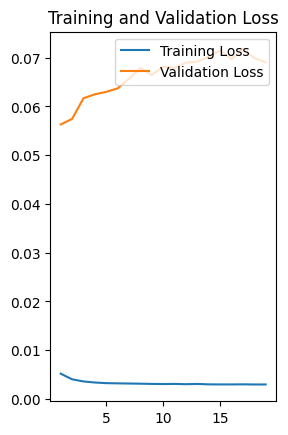

In [448]:
# visualise training loss/validation loss vs. epochs 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss[1:], label='Training Loss')
plt.plot(epochs_range, val_loss[1:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [449]:
# save the model
model.save("../normalised_models/single_variable_norm_LSTM128_batch1024_dropout0.5_Dense_lr_0.001_ws8.keras")

In [450]:
# evaluate against evaluation data
eval_loss = model.evaluate(X_eval, y_eval)
print(f"Evaluation Loss: {eval_loss}")

1218/1218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0689
Evaluation Loss: 0.06904182583093643


## Test Model Against a Real Hurricane

In [26]:
model = load_model("../models/single_variable_LDe2_WS10_E50_B64_steps_3.keras")

In [315]:
def get_points_for_sid(df, sid):
    # Filter the DataFrame for the given SID
    filtered_df = df[df['SID'] == sid]
    # Extract the x, y, and z columns and convert them to a 2D NumPy array
    points_array = filtered_df[['x', 'y', 'z']].to_numpy()
    return points_array

In [502]:
sid = "1983287N09164"

In [503]:
test_hurricane = get_points_for_sid(simple_df,sid)

In [504]:
test_hurricane

array([[-0.94942697,  0.2722438 ,  0.15643447],
       [-0.94453106,  0.28877212,  0.15643447],
       [-0.93934743,  0.30521248,  0.15643447],
       [-0.93443748,  0.31992946,  0.15643447],
       [-0.92929697,  0.33456749,  0.15643447],
       [-0.92418116,  0.34921896,  0.15471039],
       [-0.91946505,  0.36218691,  0.15298584],
       [-0.91521741,  0.37349331,  0.15126082],
       [-0.91173728,  0.38325906,  0.14780941],
       [-0.90882638,  0.39140248,  0.1443562 ],
       [-0.90627621,  0.39971543,  0.13744455],
       [-0.90339709,  0.40789943,  0.13225639],
       [-0.90061938,  0.41614458,  0.12533323],
       [-0.8971661 ,  0.42600579,  0.11667074],
       [-0.89277498,  0.43736595,  0.10799936],
       [-0.88817249,  0.44864821,  0.09931975],
       [-0.88321859,  0.4597745 ,  0.09237059],
       [-0.87863458,  0.46914718,  0.0888943 ],
       [-0.87380836,  0.4783961 ,  0.08715574],
       [-0.86802978,  0.48910965,  0.08541692],
       [-0.86286034,  0.49817265,  0.085

In [505]:
def normalise_xyz_array(array):
    norm_array = (array + 1) / 2
    return norm_array

In [506]:
def descale_xyz_array(scaled_array):
    original_array = (scaled_array * 2) -1
    return original_array

In [507]:
test_hurricane_norm = normalise_xyz_array(test_hurricane)

In [508]:
test_hurricane_norm

array([[0.02528652, 0.6361219 , 0.57821723],
       [0.02773447, 0.64438606, 0.57821723],
       [0.03032628, 0.65260624, 0.57821723],
       [0.03278126, 0.65996473, 0.57821723],
       [0.03535152, 0.66728375, 0.57821723],
       [0.03790942, 0.67460948, 0.57735519],
       [0.04026748, 0.68109346, 0.57649292],
       [0.04239129, 0.68674665, 0.57563041],
       [0.04413136, 0.69162953, 0.57390471],
       [0.04558681, 0.69570124, 0.5721781 ],
       [0.0468619 , 0.69985772, 0.56872227],
       [0.04830145, 0.70394971, 0.5661282 ],
       [0.04969031, 0.70807229, 0.56266662],
       [0.05141695, 0.71300289, 0.55833537],
       [0.05361251, 0.71868297, 0.55399968],
       [0.05591375, 0.7243241 , 0.54965987],
       [0.0583907 , 0.72988725, 0.54618529],
       [0.06068271, 0.73457359, 0.54444715],
       [0.06309582, 0.73919805, 0.54357787],
       [0.06598511, 0.74455482, 0.54270846],
       [0.06856983, 0.74908632, 0.54270846],
       [0.07113836, 0.75362807, 0.54183892],
       [0.

In [509]:
def predict_path(model, initial_sequence, steps):
    path = []
    current_sequence = initial_sequence
    
    for _ in range(steps):
        # Predict the next point
        next_point = model.predict(np.expand_dims(current_sequence, axis=0))
        
        # Append the prediction to the path
        path.append(next_point[0])
        
        # Update the current sequence by appending the predicted point
        current_sequence = np.append(current_sequence[1:], next_point, axis=0)
    
    return np.array(path)

In [510]:
# Example: Predicting the next 32 steps from the first 8 sequence in the evaluation set
predicted_path = predict_path(model, test_hurricane_norm[0:8], steps=40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

In [511]:
denorm_pred_path = descale_xyz_array(predicted_path)

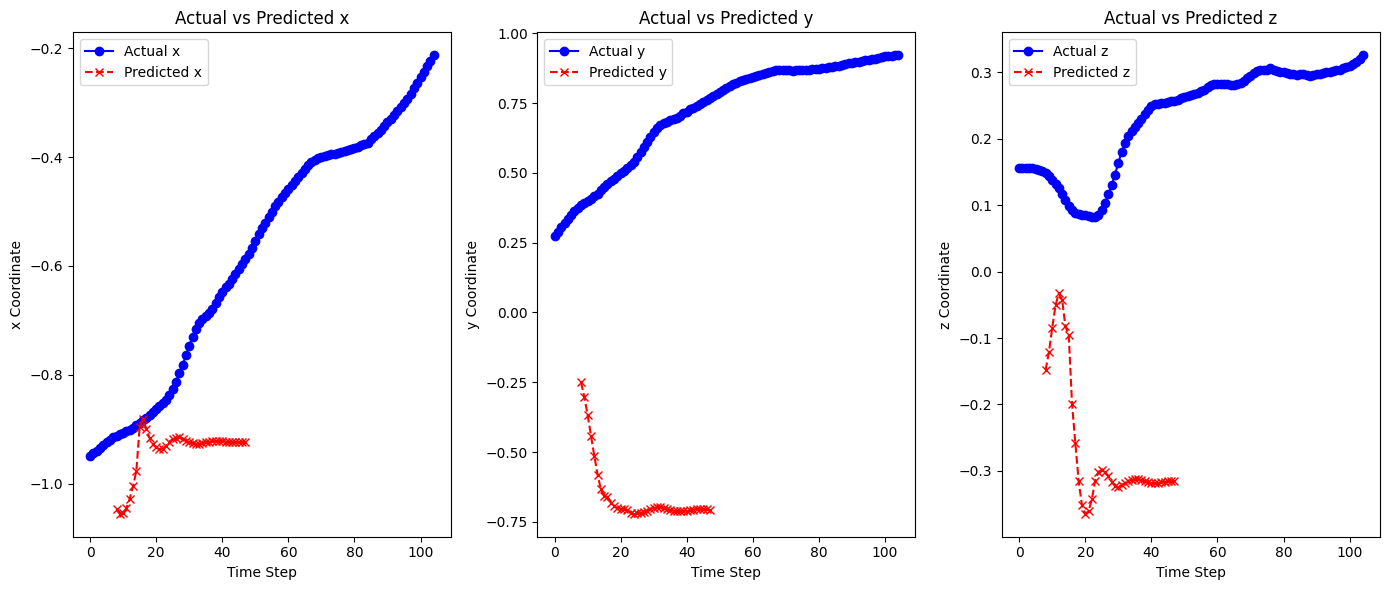

In [512]:
# visualise the performance of the model
def plot_predicted_vs_actual(actual_path, pred_path, start_index):
    # Calculate the end index based on the start index and the length of the predicted path
    end_index = start_index + len(pred_path)
    
    # Ensure the predicted path fits within the bounds of the actual path
    if end_index > len(actual_path):
        raise ValueError("Predicted path exceeds bounds of actual path. Adjust the start_index or predicted_path length.")
    
    plt.figure(figsize=(14, 6))

    # Plotting x-coordinate over time
    plt.subplot(1, 3, 1)
    plt.plot(range(len(actual_path)), actual_path[:, 0], label='Actual x', color='blue', marker='o')
    plt.plot(range(start_index, end_index), pred_path[:, 0], label='Predicted x', color='red', linestyle='--', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('x Coordinate')
    plt.title('Actual vs Predicted x')
    plt.legend()

    # Plotting y-coordinate over time
    plt.subplot(1, 3, 2)
    plt.plot(range(len(actual_path)), actual_path[:, 1], label='Actual y', color='blue', marker='o')
    plt.plot(range(start_index, end_index), pred_path[:, 1], label='Predicted y', color='red', linestyle='--', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('y Coordinate')
    plt.title('Actual vs Predicted y')
    plt.legend()

    # Plotting z-coordinate over time
    plt.subplot(1, 3, 3)
    plt.plot(range(len(actual_path)), actual_path[:, 2], label='Actual z', color='blue', marker='o')
    plt.plot(range(start_index, end_index), pred_path[:, 2], label='Predicted z', color='red', linestyle='--', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('z Coordinate')
    plt.title('Actual vs Predicted z')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_predicted_vs_actual(test_hurricane,denorm_pred_path,8)

In [513]:
def append_unit_sphere_coord(dframe):
    dframe['x'] = np.cos(np.radians(dframe.Lat)) * np.cos(np.radians(dframe.Lon))
    dframe['y'] = np.cos(np.radians(dframe.Lat)) * np.sin(np.radians(dframe.Lon))
    dframe['z'] = np.sin(np.radians(dframe.Lat))

In [514]:
def unit_sphere_to_lat_lon(x, y, z):
    lat = np.degrees(np.arcsin(z))
    lon = np.degrees(np.arctan2(y, x))
    if lon < 0:
        lon += 360
    return lat, lon

In [515]:
predicted_track_lat_lon = pd.DataFrame(columns=['Lat', 'Lon', 'x', 'y', 'z']).astype(np.float32)

In [516]:
for i in range(len(denorm_pred_path)):
    lat, lon = unit_sphere_to_lat_lon(denorm_pred_path[i][0], denorm_pred_path[i][1], denorm_pred_path[i][2])
    predicted_track_lat_lon.loc[i] = [lat, lon, denorm_pred_path[i][0], denorm_pred_path[i][1], denorm_pred_path[i][2]]

In [517]:
track_lat_lon = grouped.get_group(sid)

In [518]:
def MapTemplate(plt_title, min_lat=0, max_lat=60, min_lon=100, max_lon=280):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=180, standard_parallels=(20, 40)))
    # ax.set_extent([100, 280, 0, 60], crs=ccrs.PlateCarree())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    plt.suptitle(plt_title, fontsize=16)
    plt.tight_layout(rect=[0, 0.2, 1, 1])  # Adjust the rect parameter to leave space for the title
    return ax

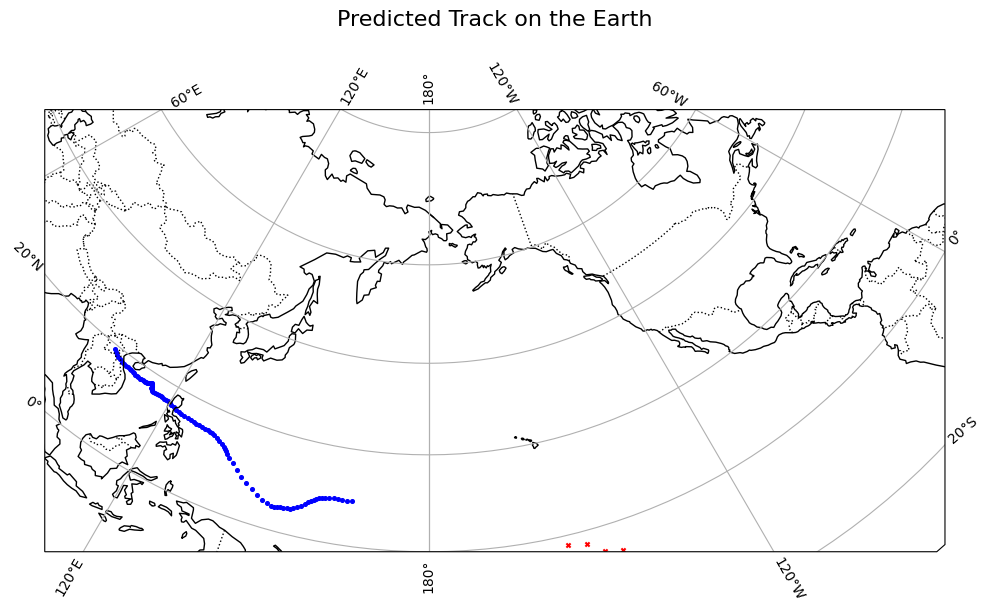

In [519]:
map = MapTemplate('Predicted Track on the Earth', min_lon=100, max_lon=300)

map.scatter(track_lat_lon['LON'].tolist(), track_lat_lon['LAT'].tolist(), transform=ccrs.PlateCarree(), color='blue', s=7, marker='o')
map.scatter(predicted_track_lat_lon['Lon'].tolist(), predicted_track_lat_lon['Lat'].tolist(), transform=ccrs.PlateCarree(), color='red', s=9, marker='x')